In [1]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#graphing functions
def plotGenotype_2D(graphInfo, title="Genotype Generation plot"):
    fig=plt.figure()
    plt.plot(graphInfo["xPlots"],graphInfo["WPlots"],'b-')
    plt.plot(graphInfo["xPlots"],graphInfo["DPlots"],'r-')
    plt.plot(graphInfo["xPlots"],graphInfo["HPlots"],'m-')
    plt.axis([0,len(graphInfo["xPlots"]),0,1])
    plt.show()
def plotAllele_2D(graphInfo, title="Allele Generation Plot"):
    fig=plt.figure()
    plt.plot(graphInfo["xPlots"],graphInfo["wPlots"],'b-')
    plt.plot(graphInfo["xPlots"],graphInfo["dPlots"],'r-')
    plt.axis([0,len(graphInfo["xPlots"]),0,1])
    plt.show()
pList=["-","+",",",".","o","*"]
linestyles=["solid","dotted","dashed","dashdot"]
def multiPlot(graphInfos, genLength, title="Allele Generation Plot", onlyGD=False):
    fig=plt.figure()
    for i in range(len(graphInfos)):
        if not onlyGD:
            plt.plot(graphInfos[i]["xPlots"],graphInfos[i]["wPlots"],'b-',linestyle=graphInfos[i]["linestyle"])
        plt.plot(graphInfos[i]["xPlots"],graphInfos[i]["dPlots"],'r-',linestyle=graphInfos[i]["linestyle"])
    plt.axis([0,genLength,0,1])
    plt.title(title)
    plt.show()
def model_3D(X,Y,Z,xLabel,yLabel, title):
    #3D graph
    import matplotlib.pyplot as plt
    from matplotlib import cm
    min=1000
    max=-1000
    for rIndex in range(len(Z)):
        for cIndex in range(len(Z[rIndex])):
            if Z[rIndex][cIndex]<min:
                min=Z[rIndex][cIndex]
            if Z[rIndex][cIndex]>max:
                max=Z[rIndex][cIndex]
    if min<-max:
        max=-min
    else:
        min=-max
    
    #label axes
    plt.xlabel(xLabel, fontdict=None, labelpad=None)
    plt.ylabel(yLabel, fontdict=None, labelpad=None)
    plt.title(title)

    
    plt.axis(aspect='image');
    plt.imshow(Z, origin='lower', extent=([0, 1, 0, 1]), vmax=max, vmin=min, cmap=cm.coolwarm)
    plt.show()

In [3]:
#model functions
def update_vars(oldDataDict, newDataDict):
    for key in newDataDict.keys():
        oldDataDict[key]=newDataDict[key]
    return oldDataDict
def run_generation_iX(simData):
    w=simData['qW']
    d=simData['qD']
    fW=simData['fW']
    fD=simData['fD']
    h=simData['h']
    fH=fW*(1-h)+fD*h
    eW=simData['eW']
    a=simData['a']
    if simData['curGen']<=simData['induceStart']:
        eD=simData['eD']
    else:
        eD=simData['eD']*(1-a)+simData['eDP']*a
    #prevent redundant multiplication and create less rounding errors
    w2=w*w
    wd=w*d
    d2=d*d
    #ed2=eD because of the way finn and I discussed
    ed2=eD
    edew=eD*eW
    ednew=eD*(1-eW)
    nedew=(1-eD)*eW
    nednew=(1-eD)*(1-eW)
    
    fBar=1-((1-fW)*(w2+2*wd*ednew)+(1-fD)*(d2*(1-ed2)+2*wd*nedew)+(1-fH)*(2*wd*nednew)+d2*ed2+2*wd*edew)
    wPrime=(w2+2*wd*ednew)*fW + (wd*nednew)*fH
    dPrime=(d2*(1-ed2)+2*wd*nedew)*fD + (wd*nednew)*fH
    
    #wPrime=(fW*w2+fH*(wd*(1-e)))/fBar
    #dPrime=(fD*(d2+2*wd*e)+fH*(wd*(1-e)))/fBar
    #print({'w':wPrime, 'd':dPrime,'fB':1-fBar})
    #print(wPrime+dPrime+(1-fBar))
    wPrime/=fBar
    dPrime/=fBar
    
    #remove rounding errors
    total=wPrime+dPrime
    if total!=1:
        wPrime/=total
        dPrime/=total

    fBar=1-(d2*eD*eD)
    homoW=(w2+2*wd*eD*(1-eW))/fBar
    homoD=(d2*(1-eD*eD)+2*wd*(1-eD)*eW)/fBar
    heterozygote=(2*wd*(1-eD)*(1-eW))/fBar
    
    #print(str(simData['curGen'])+' '+str(heterozygote))
    return {'qW':wPrime,'qD':dPrime,'WW':homoW,'DD':homoD,'WD':heterozygote}

    
def run_simulation_iX(simData,graph=False,debug=False):
    graphInfo={"xPlots": [0], "WPlots": [simData['qW']], "DPlots": [simData['qD']], "HPlots": [0], "wPlots":[simData['qW']], "dPlots":[simData['qD']]}
    w=simData['qW']*simData['fW']
    d=simData['qD']*simData['fD']
    total=w+d
    simData['qW']=w/total
    simData['qD']=d/total
    for i in range(1,simData['generations']+1):
        simData['curGen']=i
        update_vars(simData,run_generation_iX(simData))
        graphInfo['xPlots'].append(i)
        graphInfo['wPlots'].append(simData['qW'])
        graphInfo['dPlots'].append(simData['qD'])
        graphInfo['WPlots'].append(simData['WW'])
        graphInfo['DPlots'].append(simData['DD'])
        graphInfo['HPlots'].append(simData['WD'])
        if simData['qW']>.99999:
            if graph:
                plotGenotype_2D(graphInfo)
                plotAllele_2D(graphInfo)
            if debug:
                print(pd.DataFrame(graphInfo))
            return graphInfo
        elif simData['qD']>.99999:
            if graph:
                plotGenotype_2D(graphInfo)
                plotAllele_2D(graphInfo)
            if debug:
                print(pd.DataFrame(graphInfo))
            return graphInfo
    if graph:
        plotGenotype_2D(graphInfo)
        plotAllele_2D(graphInfo)
    if debug:
        print(pd.DataFrame(graphInfo))
    return graphInfo

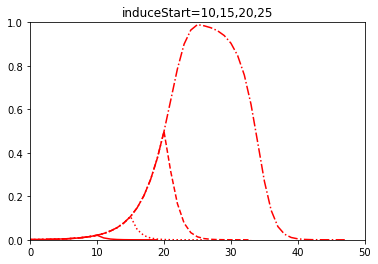

In [4]:
#change induceStart
linestyles=["solid","dotted","dashed","dashdot"]
gis=[]
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.9,'generations':1000, 'induceStart':10}
gis.append(run_simulation_iX(simData))
gis[0]["linestyle"]="solid"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.9,'generations':100, 'induceStart':15}
gis.append(run_simulation_iX(simData))
gis[1]["linestyle"]="dotted"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.9,'generations':100, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[2]["linestyle"]="dashed"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.9,'generations':100, 'induceStart':25}
gis.append(run_simulation_iX(simData))
gis[3]["linestyle"]="dashdot"
#multiPlot(gis,50,"induceStart=10,15,20,25")
multiPlot(gis,50,"induceStart=10,15,20,25",True)

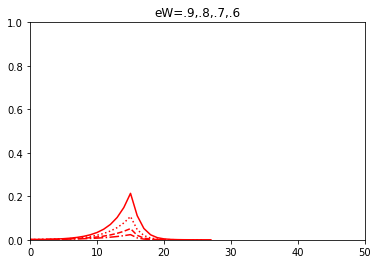

In [5]:
#change eW
linestyles=["solid","dotted","dashed","dashdot"]
gis=[]
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.9,'eD':.05,'eDP':.8,'a':.9,'generations':1000, 'induceStart':15}
gis.append(run_simulation_iX(simData))
gis[0]["linestyle"]="solid"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.9,'generations':100, 'induceStart':15}
gis.append(run_simulation_iX(simData))
gis[1]["linestyle"]="dotted"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.7,'eD':.05,'eDP':.8,'a':.9,'generations':100, 'induceStart':15}
gis.append(run_simulation_iX(simData))
gis[2]["linestyle"]="dashed"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.6,'eD':.05,'eDP':.8,'a':.9,'generations':100, 'induceStart':15}
gis.append(run_simulation_iX(simData))
gis[3]["linestyle"]="dashdot"
#multiPlot(gis,50,"eW=.9,.8,.7,.6")
multiPlot(gis,50,"eW=.9,.8,.7,.6",True)

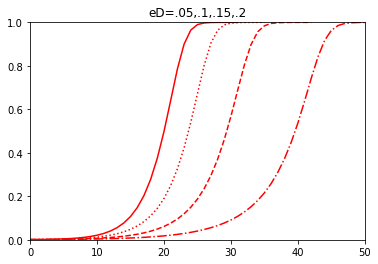

In [6]:
#change eD (leaky) -noInduce
linestyles=["solid","dotted","dashed","dashdot"]
gis=[]
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':0,'generations':1000, 'induceStart':10}
gis.append(run_simulation_iX(simData))
gis[0]["linestyle"]="solid"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.1,'eDP':.8,'a':0,'generations':1000, 'induceStart':10}
gis.append(run_simulation_iX(simData))
gis[1]["linestyle"]="dotted"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.15,'eDP':.8,'a':0,'generations':1000, 'induceStart':10}
gis.append(run_simulation_iX(simData))
gis[2]["linestyle"]="dashed"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.2,'eDP':.8,'a':0,'generations':1000, 'induceStart':10}
gis.append(run_simulation_iX(simData))
gis[3]["linestyle"]="dashdot"
#multiPlot(gis,50,"eD=.05,.1,.15,.2")

multiPlot(gis,50,"eD=.05,.1,.15,.2",True)

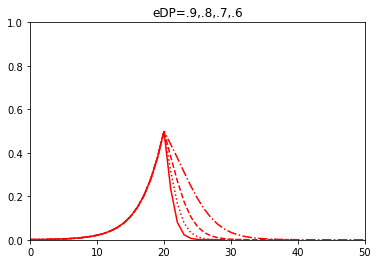

In [7]:
#change eDP
linestyles=["solid","dotted","dashed","dashdot"]
gis=[]
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.9,'a':.9,'generations':1000, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[0]["linestyle"]="solid"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.9,'generations':1000, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[1]["linestyle"]="dotted"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.7,'a':.9,'generations':1000, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[2]["linestyle"]="dashed"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.6,'a':.9,'generations':1000, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[3]["linestyle"]="dashdot"
#multiPlot(gis,50,"eDP=.9,.8,.7,.6")
multiPlot(gis,50,"eDP=.9,.8,.7,.6",True)

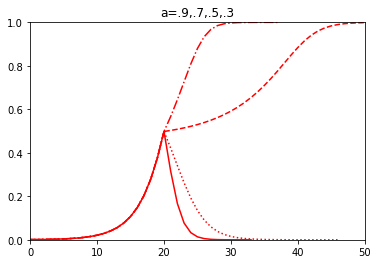

In [8]:
#change a
linestyles=["solid","dotted","dashed","dashdot"]
gis=[]
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.9,'generations':1000, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[0]["linestyle"]="solid"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.7,'generations':1000, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[1]["linestyle"]="dotted"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.5,'generations':1000, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[2]["linestyle"]="dashed"
simData={'qW':.999,'qD':.001,'qH':0,'fW':1,'fD':.8,'h':.5,'eW':.8,'eD':.05,'eDP':.8,'a':.3,'generations':1000, 'induceStart':20}
gis.append(run_simulation_iX(simData))
gis[3]["linestyle"]="dashdot"
#multiPlot(gis,50,"a=.9,.7,.5,.3")
multiPlot(gis,50,"a=.9,.7,.5,.3",True)